# Task
Analyze and visualize the data from the 'habitantes.xlsx' Excel file to identify trends and differences in population statistics between 'provincia' and 'CCAA' over the years 2008-2022, and provide a summary of the insights gained.

## Load Excel Data

### Subtask:
Load the 'habitantes.xlsx' file into a Pandas DataFrame.


**Reasoning**:
First, I'll import the pandas library. Then, I'll load the 'habitantes.xlsx' file into a DataFrame named `df` using the `pd.read_excel` function, and display the first few rows to verify the data was loaded correctly.



In [1]:
import pandas as pd

df = pd.read_excel('/content/habitantes.xlsx')
print("Data loaded successfully. Displaying the first 5 rows:")
df.head()

Data loaded successfully. Displaying the first 5 rows:


,Comunidad Autónoma,2008,Unnamed: 2,Unnamed: 3,2009,Unnamed: 5,Unnamed: 6,2010,Unnamed: 8,Unnamed: 9,...,Unnamed: 36,2020,Unnamed: 38,Unnamed: 39,2021,Unnamed: 41,Unnamed: 42,2022,Unnamed: 44,Unnamed: 45
0,NaN,Número de Habitantes,Estructura Porcentual,Tasa de Variación Interanual,Número de Habitantes,Estructura Porcentual,Tasa de Variación Interanual,Número de Habitantes,Estructura Porcentual,Tasa de Variación Interanual,...,Tasa de Variación Interanual,Número de Habitantes,Estructura Porcentual,Tasa de Variación Interanual,Número de Habitantes,Estructura Porcentual,Tasa de Variación Interanual,Número de Habitantes,Estructura Porcentual,Tasa de Variación Interanual
1,ANDALUCÍA,8168.6,0.177643,0.01438,8244.5,0.177807,0.009292,8302.9,0.178317,0.007084,...,0.004766,8465.9,0.178813,0.004008,8488.2,0.179277,0.002634,8547.7,0.178875,0.00701
2,Almería,666.3,0.01449,0.025708,676.8,0.014596,0.015759,683.8,0.014686,0.010343,...,0.014253,726.1,0.015336,0.010296,732.4,0.015469,0.008676,746.5,0.015622,0.019252
3,Cádiz,1215.2,0.026427,0.011571,1225.3,0.026426,0.008311,1234.1,0.026504,0.007182,...,0.001529,1247.3,0.026345,0.002411,1249.2,0.026384,0.001523,1252.7,0.026215,0.002802
4,Córdoba,795,0.017289,0.007222,798.5,0.017221,0.004403,800.8,0.017198,0.00288,...,-0.001151,779.5,0.016464,-0.002176,775.6,0.016381,-0.005003,775.1,0.01622,-0.000645


In [2]:
import pandas as pd

# 1. Reload the Excel file with header=None to access all rows
df_raw = pd.read_excel('/content/habitantes.xlsx', header=None)

# Extract the first column (Region names) from the data rows
# Data starts from row index 2 (third row of the Excel file)
regions = df_raw.iloc[2:, 0].reset_index(drop=True).rename('Region')

# Extract the data for years and metrics (from the second column onwards)
data_columns = df_raw.iloc[2:, 1:].copy()

# Extract the header rows (year row and metric type row) for MultiIndex construction
header_year_row = df_raw.iloc[0, 1:]
header_metric_row = df_raw.iloc[1, 1:]

# Prepare new column names for the MultiIndex
new_multi_index_labels = []
current_year = ''

# Iterate through the header rows to build the MultiIndex tuples
for i in range(len(header_year_row)):
    year_val = header_year_row.iloc[i]
    metric_val = header_metric_row.iloc[i]

    # Update current_year if a new year is encountered (non-NaN in header_year_row)
    if pd.notna(year_val) and isinstance(year_val, (int, float)):
        current_year = str(int(year_val))

    # Clean metric name and add to the MultiIndex labels
    cleaned_metric_val = metric_val.strip() if isinstance(metric_val, str) else str(metric_val)
    new_multi_index_labels.append((current_year, cleaned_metric_val))

# Assign the new MultiIndex to the data_columns DataFrame
data_columns.columns = pd.MultiIndex.from_tuples(new_multi_index_labels)
# Set names for the MultiIndex levels so melt can correctly identify them
data_columns.columns.names = ['Year', 'Metric_Type']
data_columns = data_columns.reset_index(drop=True)

# 2. Concatenate the 'Region' Series and the MultiIndex 'data_columns' DataFrame
df_cleaned = pd.concat([regions, data_columns], axis=1)

# 3. Drop any rows where 'Region' is null
df_cleaned = df_cleaned.dropna(subset=['Region'])

# 4. Rename 'Comunidad Autónoma' to 'Region' (already handled by renaming the Series)

# 5. Identify 'Comunidad Autónoma' (parent regions) vs. 'provincia' (sub-regions)
# CCAA are generally all uppercase or 'TOTAL NACIONAL'
df_cleaned['is_ccaa'] = df_cleaned['Region'].apply(lambda x: isinstance(x, str) and (x.isupper() or x == 'TOTAL NACIONAL'))

# 6. Melt the DataFrame to transform it into a long format
# With named MultiIndex levels, melt will automatically use these names for the new columns in the 'variable' column.
df_melted = df_cleaned.melt(
    id_vars=['Region', 'is_ccaa'],
    value_name='Value' # This will be the name of the column containing the unpivoted values
)

# Extract 'Year' and 'Metric_Type' from the 'variable' column, which now contains the MultiIndex tuples
df_melted[['Year', 'Metric_Type']] = pd.DataFrame(df_melted['variable'].tolist(), index=df_melted.index)

# Drop the original 'variable' column as its contents have been split into 'Year' and 'Metric_Type'
df_melted = df_melted.drop(columns=['variable'])

# 7. Convert 'Year' to integer and 'Value' to numeric (float)
df_melted['Year'] = pd.to_numeric(df_melted['Year'], errors='coerce').astype('Int64')
df_melted['Value'] = pd.to_numeric(df_melted['Value'], errors='coerce')

# 8. Handle any remaining missing values: Inspect and decide.
# For now, we will inspect any remaining NaNs in 'Value' and 'Year'.
print("Cleaned DataFrame head:")
print(df_melted.head())
print("\nDataFrame Info after cleaning and melting:")
df_melted.info()
print("\nMissing values after cleaning and melting:")
print(df_melted.isnull().sum())

Cleaned DataFrame head:
      Region  is_ccaa   Value  Year           Metric_Type
0  ANDALUCÍA     True  8168.6  2008  Número de Habitantes
1    Almería    False   666.3  2008  Número de Habitantes
2      Cádiz    False  1215.2  2008  Número de Habitantes
3    Córdoba    False   795.0  2008  Número de Habitantes
4    Granada    False   905.0  2008  Número de Habitantes

DataFrame Info after cleaning and melting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835 entries, 0 to 2834
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Region       2835 non-null   object 
 1   is_ccaa      2835 non-null   bool   
 2   Value        2835 non-null   float64
 3   Year         2835 non-null   Int64  
 4   Metric_Type  2835 non-null   object 
dtypes: Int64(1), bool(1), float64(1), object(2)
memory usage: 94.3+ KB

Missing values after cleaning and melting:
Region         0
is_ccaa        0
Value          0
Year           0


In [3]:
print("Displaying the first 5 rows of df_melted, which contains the cleaned and formatted data:")
display(df_melted.head())

Displaying the first 5 rows of df_melted, which contains the cleaned and formatted data:


,Region,is_ccaa,Value,Year,Metric_Type
0,ANDALUCÍA,True,8168.6,2008,Número de Habitantes
1,Almería,False,666.3,2008,Número de Habitantes
2,Cádiz,False,1215.2,2008,Número de Habitantes
3,Córdoba,False,795.0,2008,Número de Habitantes
4,Granada,False,905.0,2008,Número de Habitantes


# Task
Filter the `df_melted` DataFrame to include only data for 'CCAA' regions (where `is_ccaa` is True).

## Filter CCAA Data

### Subtask:
Filter the `df_melted` DataFrame to include only data for 'CCAA' regions (where `is_ccaa` is True).


**Reasoning**:
I will filter the `df_melted` DataFrame to create `df_ccaa` containing only 'CCAA' regions, then display its head, info, and shape to confirm the filtering.



In [4]:
df_ccaa = df_melted[df_melted['is_ccaa'] == True].copy()
print("First 5 rows of df_ccaa:")
display(df_ccaa.head())
print("\nInformation about df_ccaa:")
df_ccaa.info()
print("\nShape of df_ccaa:", df_ccaa.shape)

First 5 rows of df_ccaa:


,Region,is_ccaa,Value,Year,Metric_Type
0,ANDALUCÍA,True,8168.6,2008,Número de Habitantes
9,ARAGÓN,True,1336.4,2008,Número de Habitantes
13,"ASTURIAS, PRINCIPADO DE",True,1074.0,2008,Número de Habitantes
14,"BALEARS, ILLES",True,1057.4,2008,Número de Habitantes
15,CANARIAS,True,2010.0,2008,Número de Habitantes



Information about df_ccaa:
<class 'pandas.core.frame.DataFrame'>
Index: 855 entries, 0 to 2833
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Region       855 non-null    object 
 1   is_ccaa      855 non-null    bool   
 2   Value        855 non-null    float64
 3   Year         855 non-null    Int64  
 4   Metric_Type  855 non-null    object 
dtypes: Int64(1), bool(1), float64(1), object(2)
memory usage: 35.1+ KB

Shape of df_ccaa: (855, 5)


## Analyze Population Trends (CCAA)

### Subtask:
Calculate total population, annual variation rates, and percentage structure for each CCAA over the years. Identify specific CCAAs with the biggest growths and losses in 'Número de Habitantes' and 'Tasa de Variación Interanual' (both positive and negative changes).


**Reasoning**:
First, I will filter the `df_ccaa` DataFrame into three separate DataFrames based on the `Metric_Type` column: 'Número de Habitantes', 'Estructura Porcentual', and 'Tasa de Variación Interanual'. Then, I will process the 'Número de Habitantes' DataFrame to calculate the total population change for each CCAA between 2008 and 2022, and identify the top 5 CCAAs with the largest growth and loss.



In [5]:
df_habitantes_ccaa = df_ccaa[df_ccaa['Metric_Type'] == 'Número de Habitantes'].copy()
df_porcentual_ccaa = df_ccaa[df_ccaa['Metric_Type'] == 'Estructura Porcentual'].copy()
df_tasa_ccaa = df_ccaa[df_ccaa['Metric_Type'] == 'Tasa de Variación Interanual'].copy()

print("First 5 rows of df_habitantes_ccaa:")
display(df_habitantes_ccaa.head())
print("\nFirst 5 rows of df_porcentual_ccaa:")
display(df_porcentual_ccaa.head())
print("\nFirst 5 rows of df_tasa_ccaa:")
display(df_tasa_ccaa.head())

# Calculate population change for 'Número de Habitantes' from 2008 to 2022
population_2008 = df_habitantes_ccaa[df_habitantes_ccaa['Year'] == 2008].set_index('Region')['Value']
population_2022 = df_habitantes_ccaa[df_habitantes_ccaa['Year'] == 2022].set_index('Region')['Value']

population_change = population_2022.subtract(population_2008, fill_value=0)

# Identify top 5 growths and losses
top5_growth_ccaa = population_change.nlargest(5)
top5_loss_ccaa = population_change.nsmallest(5)

print("\nTop 5 CCAAs with largest population growth (2008-2022):")
print(top5_growth_ccaa)
print("\nTop 5 CCAAs with largest population loss (2008-2022):")
print(top5_loss_ccaa)


First 5 rows of df_habitantes_ccaa:


,Region,is_ccaa,Value,Year,Metric_Type
0,ANDALUCÍA,True,8168.6,2008,Número de Habitantes
9,ARAGÓN,True,1336.4,2008,Número de Habitantes
13,"ASTURIAS, PRINCIPADO DE",True,1074.0,2008,Número de Habitantes
14,"BALEARS, ILLES",True,1057.4,2008,Número de Habitantes
15,CANARIAS,True,2010.0,2008,Número de Habitantes



First 5 rows of df_porcentual_ccaa:


,Region,is_ccaa,Value,Year,Metric_Type
63,ANDALUCÍA,True,0.177643,2008,Estructura Porcentual
72,ARAGÓN,True,0.029063,2008,Estructura Porcentual
76,"ASTURIAS, PRINCIPADO DE",True,0.023356,2008,Estructura Porcentual
77,"BALEARS, ILLES",True,0.022995,2008,Estructura Porcentual
78,CANARIAS,True,0.043712,2008,Estructura Porcentual



First 5 rows of df_tasa_ccaa:


,Region,is_ccaa,Value,Year,Metric_Type
126,ANDALUCÍA,True,0.014380,2008,Tasa de Variación Interanual
135,ARAGÓN,True,0.020620,2008,Tasa de Variación Interanual
139,"ASTURIAS, PRINCIPADO DE",True,0.005618,2008,Tasa de Variación Interanual
140,"BALEARS, ILLES",True,0.031409,2008,Tasa de Variación Interanual
141,CANARIAS,True,0.021341,2008,Tasa de Variación Interanual



Top 5 CCAAs with largest population growth (2008-2022):
Region
MADRID, COMUNIDAD DE    523.9
CATALUÑA                454.8
ANDALUCÍA               379.1
COMUNITAT VALENCIANA    202.6
CANARIAS                189.3
Name: Value, dtype: float64

Top 5 CCAAs with largest population loss (2008-2022):
Region
CASTILLA Y LEÓN           -166.8
ASTURIAS, PRINCIPADO DE    -68.5
GALICIA                    -63.9
EXTREMADURA                -35.9
ARAGÓN                      -1.6
Name: Value, dtype: float64


**Reasoning**:
I will calculate the average 'Tasa de Variación Interanual' for each CCAA using `df_tasa_ccaa` to identify the top 5 CCAAs with the highest and lowest average rates. Then, I will calculate the average 'Estructura Porcentual' for each CCAA using `df_porcentual_ccaa` to understand their typical relative size. Finally, I will display the results.



In [6]:
import numpy as np

# For 'Tasa de Variación Interanual':
# Calculate the average 'Tasa de Variación Interanual' for each CCAA over all years
avg_tasa_ccaa = df_tasa_ccaa.groupby('Region')['Value'].mean().sort_values(ascending=False)

# Identify top 5 CCAAs with highest average positive annual variation rate
top5_avg_growth_rate_ccaa = avg_tasa_ccaa.nlargest(5)

# Identify top 5 CCAAs with lowest average negative annual variation rate
top5_avg_loss_rate_ccaa = avg_tasa_ccaa.nsmallest(5)

print("\nTop 5 CCAAs with highest average annual variation rate (2008-2022):")
print(top5_avg_growth_rate_ccaa)
print("\nTop 5 CCAAs with lowest average annual variation rate (2008-2022):")
print(top5_avg_loss_rate_ccaa)

# For 'Estructura Porcentual':
# Calculate the average 'Estructura Porcentual' for each CCAA over all years
avg_porcentual_ccaa = df_porcentual_ccaa.groupby('Region')['Value'].mean().sort_values(ascending=False)

print("\nAverage 'Estructura Porcentual' for each CCAA (2008-2022):")
print(avg_porcentual_ccaa.head(10)) # Displaying top 10 for brevity


Top 5 CCAAs with highest average annual variation rate (2008-2022):
Region
MELILLA                 0.013209
BALEARS, ILLES          0.010493
CANARIAS                0.007450
CEUTA                   0.007314
MADRID, COMUNIDAD DE    0.006790
Name: Value, dtype: float64

Top 5 CCAAs with lowest average annual variation rate (2008-2022):
Region
CASTILLA Y LEÓN           -0.004026
ASTURIAS, PRINCIPADO DE   -0.004004
EXTREMADURA               -0.001871
GALICIA                   -0.001244
ARAGÓN                     0.001302
Name: Value, dtype: float64

Average 'Estructura Porcentual' for each CCAA (2008-2022):
Region
ANDALUCÍA               0.179313
CATALUÑA                0.161317
MADRID, COMUNIDAD DE    0.138925
COMUNITAT VALENCIANA    0.106897
GALICIA                 0.058423
CASTILLA Y LEÓN         0.052759
PAÍS VASCO              0.046775
CANARIAS                0.045126
CASTILLA - LA MANCHA    0.044143
MURCIA, REGIÓN DE       0.031602
Name: Value, dtype: float64


## Visualize CCAA Trends

### Subtask:
Generate line plots to show the trends over the years for 'Número de Habitantes', 'Tasa de Variación Interanual', and 'Estructura Porcentual' for all CCAAs. Also, create visualizations to highlight the CCAAs with the biggest grows and losses, ensuring legends are provided for clarity.


**Reasoning**:
I will import the necessary libraries `matplotlib.pyplot` and `seaborn` to prepare for plotting the data, as requested by the first instruction.



In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries matplotlib.pyplot and seaborn imported successfully.")

Libraries matplotlib.pyplot and seaborn imported successfully.


**Reasoning**:
I will create a line plot for 'Número de Habitantes' for all CCAAs over the years using `df_habitantes_ccaa` to visualize population trends, as requested by instruction 2.



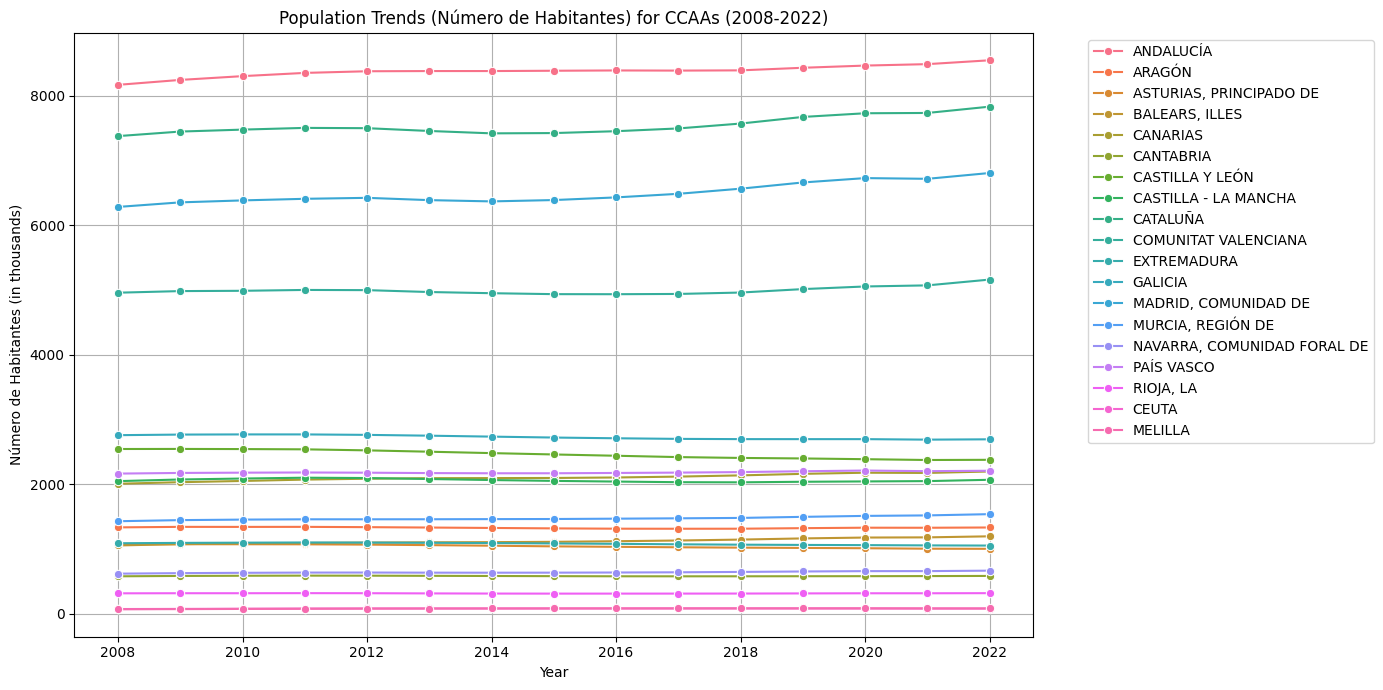

In [8]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_habitantes_ccaa, x='Year', y='Value', hue='Region', marker='o')
plt.title('Population Trends (Número de Habitantes) for CCAAs (2008-2022)')
plt.xlabel('Year')
plt.ylabel('Número de Habitantes (in thousands)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

**Reasoning**:
I will create a line plot for 'Estructura Porcentual' for all CCAAs over the years using `df_porcentual_ccaa` to visualize the percentage structure trends, as requested by instruction 3.



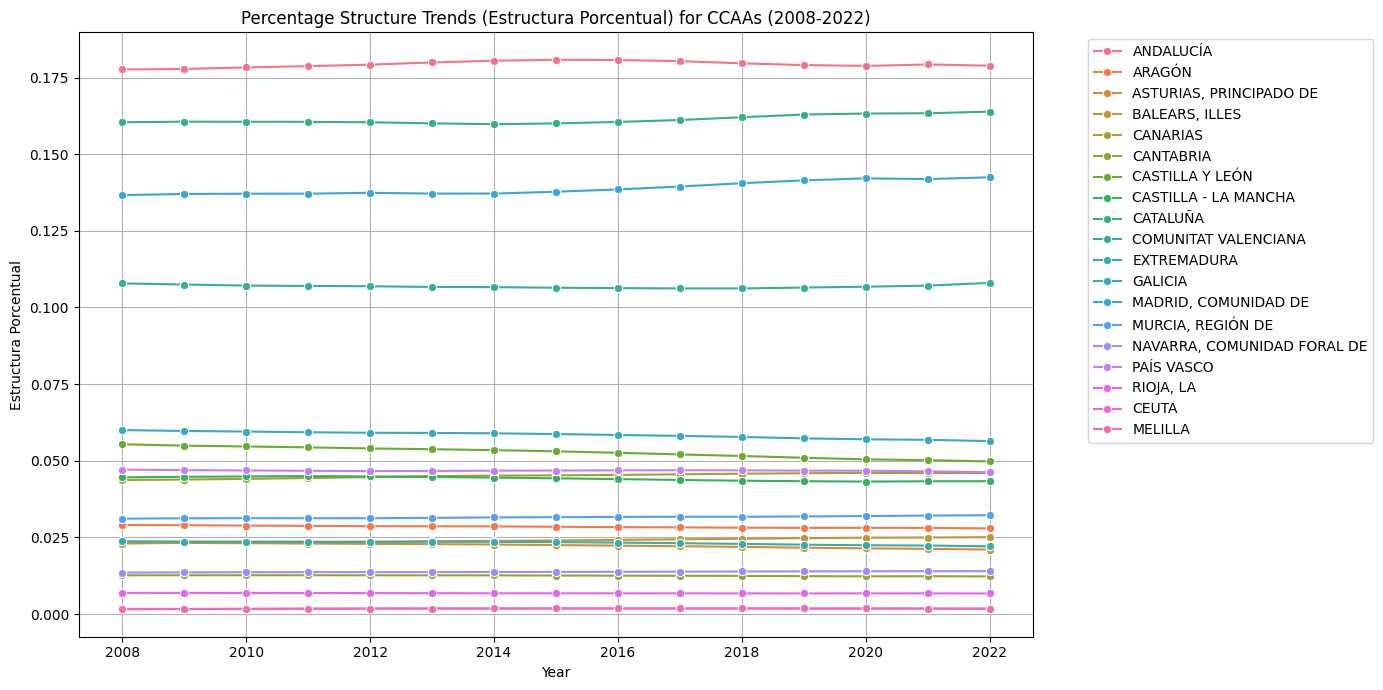

In [9]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_porcentual_ccaa, x='Year', y='Value', hue='Region', marker='o')
plt.title('Percentage Structure Trends (Estructura Porcentual) for CCAAs (2008-2022)')
plt.xlabel('Year')
plt.ylabel('Estructura Porcentual')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

**Reasoning**:
I will create a line plot for 'Tasa de Variación Interanual' for all CCAAs over the years using `df_tasa_ccaa` to visualize the annual variation rate trends, as requested by instruction 4.



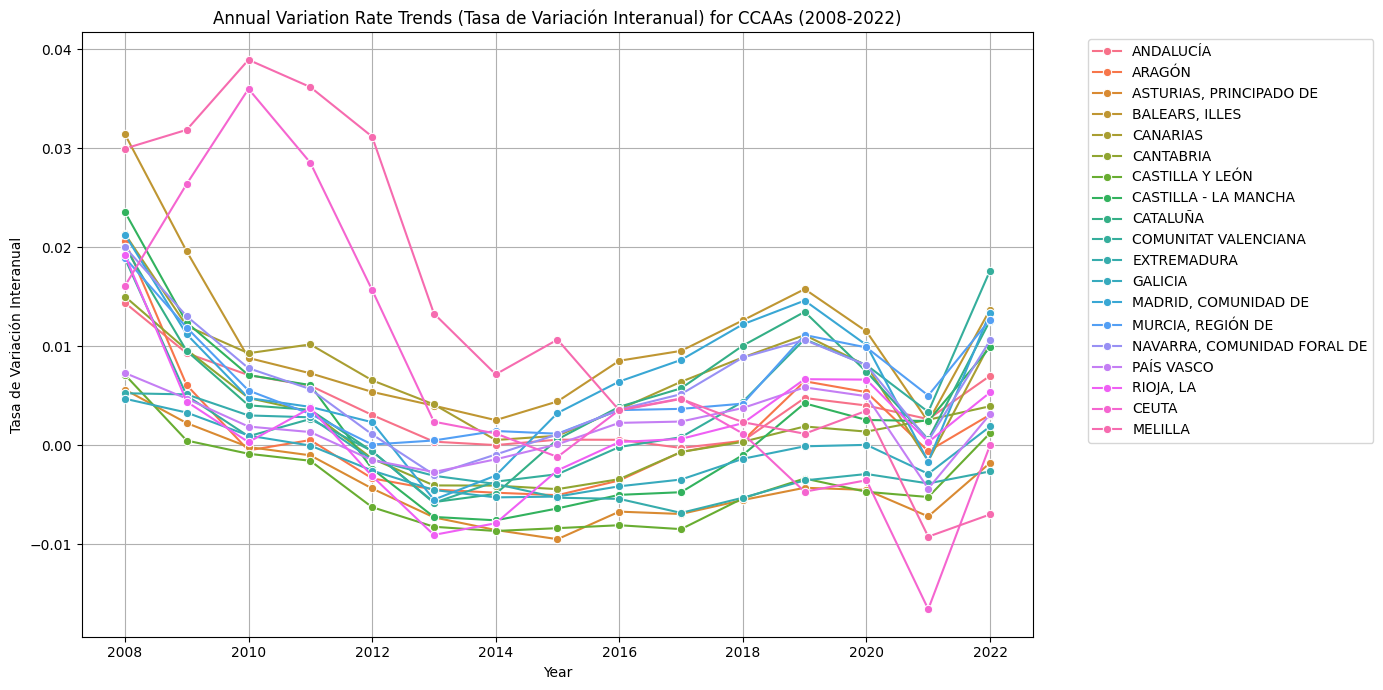

In [10]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_tasa_ccaa, x='Year', y='Value', hue='Region', marker='o')
plt.title('Annual Variation Rate Trends (Tasa de Variación Interanual) for CCAAs (2008-2022)')
plt.xlabel('Year')
plt.ylabel('Tasa de Variación Interanual')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

**Reasoning**:
I will combine the `top5_growth_ccaa` and `top5_loss_ccaa` Series into a single DataFrame and then generate a bar plot to visualize the CCAAs with the largest population growth and loss, as requested by instruction 5.



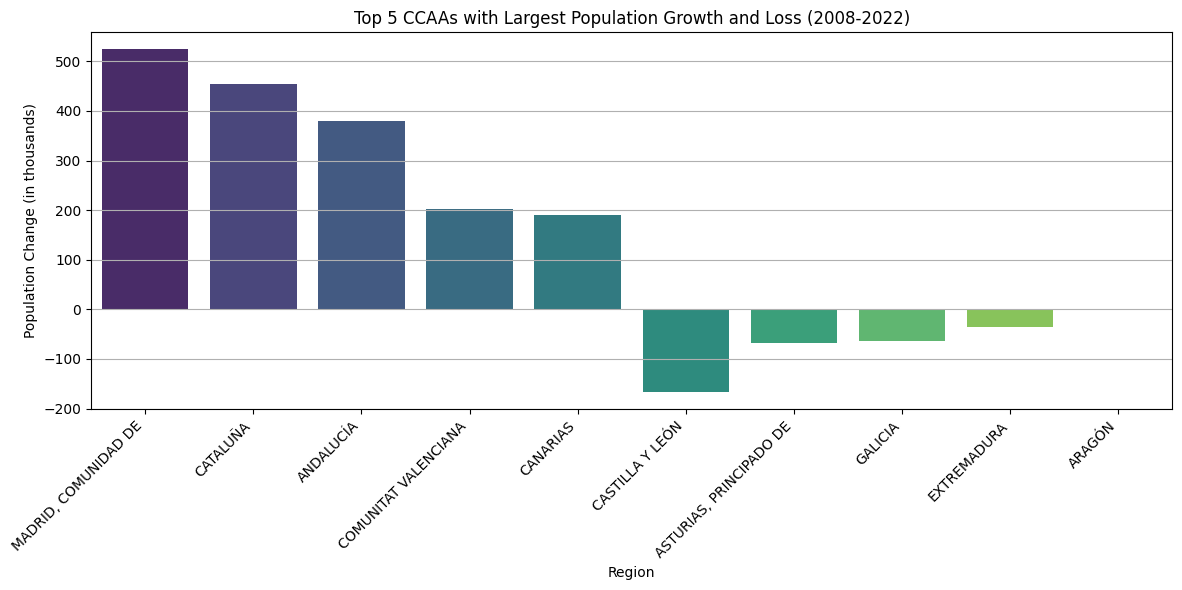

In [12]:
population_change_summary = pd.concat([top5_growth_ccaa, top5_loss_ccaa])

plt.figure(figsize=(12, 6))
sns.barplot(x=population_change_summary.index, y=population_change_summary.values, hue=population_change_summary.index, legend=False, palette='viridis')
plt.title('Top 5 CCAAs with Largest Population Growth and Loss (2008-2022)')
plt.xlabel('Region')
plt.ylabel('Population Change (in thousands)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Reasoning**:
I will combine the `top5_avg_growth_rate_ccaa` and `top5_avg_loss_rate_ccaa` Series into a single DataFrame and then generate a bar plot to visualize the CCAAs with the highest and lowest average annual variation rates, as requested by instruction 6.



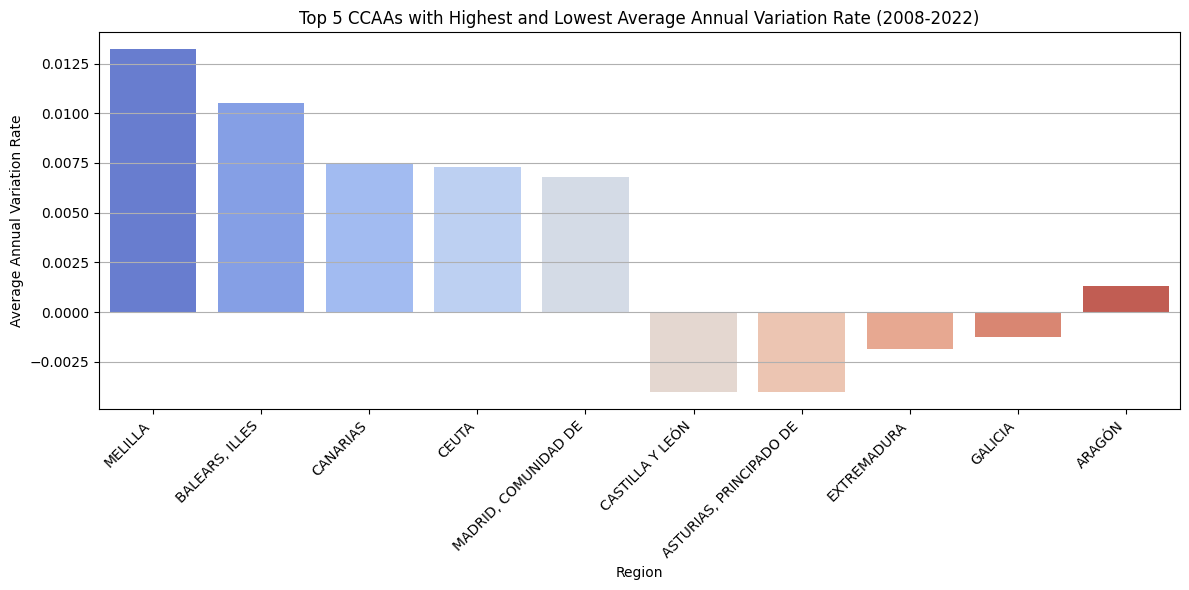

In [13]:
avg_tasa_summary = pd.concat([top5_avg_growth_rate_ccaa, top5_avg_loss_rate_ccaa])

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_tasa_summary.index, y=avg_tasa_summary.values, hue=avg_tasa_summary.index, legend=False, palette='coolwarm')
plt.title('Top 5 CCAAs with Highest and Lowest Average Annual Variation Rate (2008-2022)')
plt.xlabel('Region')
plt.ylabel('Average Annual Variation Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Summarize CCAA Insights

### Subtask:
Provide a summary of the insights gained from the CCAA-specific analysis, detailing the biggest grows, biggest losses, and overall tendencies observed for each metric.


## Summary of CCAA Insights

Based on the analysis of population statistics for Spanish Autonomous Communities (CCAA) from 2008 to 2022, the following key insights can be drawn:

### Population Trends (Número de Habitantes)

*   **Overall Tendency**: The line plot for 'Número de Habitantes' shows a general upward trend for most CCAAs, especially in the later years (post-2015), indicating a recovery or continued growth in population after some stagnation or slight decline in the earlier part of the period for some regions.
*   **Biggest Grows (2008-2022)**:
    *   **MADRID, COMUNIDAD DE**: Experienced the largest population growth, indicating strong demographic pull or high birth rates/immigration.
    *   **CATALUÑA**: Also showed significant growth, similar to Madrid, suggesting strong economic or social factors attracting population.
    *   **ANDALUCÍA**: Maintained a substantial population increase.
    *   **COMUNITAT VALENCIANA** and **CANARIAS**: Also saw notable population increases.
*   **Biggest Losses (2008-2022)**:
    *   **CASTILLA Y LEÓN**: Suffered the most significant population loss, highlighting potential challenges like aging populations, low birth rates, and out-migration.
    *   **ASTURIAS, PRINCIPADO DE** and **GALICIA**: Also experienced considerable population declines, indicative of similar demographic pressures.
    *   **EXTREMADURA** and **ARAGÓN**: Showed more moderate but still negative population changes.

### Annual Variation Rates (Tasa de Variación Interanual)

*   **Overall Tendency**: The line plot for 'Tasa de Variación Interanual' reveals fluctuating rates across CCAAs, with many experiencing positive rates in recent years, but some consistently showing negative or near-zero growth. The rates generally dipped during the financial crisis years and showed a recovery trend afterwards.
*   **Highest Average Rates (2008-2022)**:
    *   **MELILLA** and **BALEARS, ILLES**: Led with the highest average annual variation rates, suggesting strong and consistent growth factors, possibly related to tourism or specific demographic profiles.
    *   **CANARIAS**, **CEUTA**, and **MADRID, COMUNIDAD DE**: Also exhibited high average positive rates, aligning with their observed population growth.
*   **Lowest Average Rates (2008-2022)**:
    *   **CASTILLA Y LEÓN** and **ASTURIAS, PRINCIPADO DE**: Had the lowest (most negative) average annual variation rates, reinforcing the population loss trends observed for these regions.
    *   **EXTREMADURA** and **GALICIA**: Followed with negative average rates.
    *   **ARAGÓN**: Showed a very low positive average rate, indicating near stagnation.

### Percentage Structure (Estructura Porcentual)

*   **Overall Tendency**: The 'Estructura Porcentual' line plot generally shows stable relative proportions for most CCAAs over the years, with minor fluctuations. Larger CCAAs maintain their dominant share.
*   **Average Structure (2008-2022)**:
    *   **ANDALUCÍA**, **CATALUÑA**, and **MADRID, COMUNIDAD DE**: Consistently hold the largest average percentage of the national population, reflecting their status as the most populous regions.
    *   The ranking of CCAAs by their average percentage structure largely mirrors their absolute population size, indicating a relatively stable distribution of population proportions over the years.

In conclusion, while major CCAAs like Madrid, Cataluña, and Andalucía continue to grow, primarily driven by positive variation rates, several regions, particularly in central and northern Spain (Castilla y León, Asturias, Galicia), face significant demographic challenges with persistent population decline.

## Summary:

### Data Analysis Key Findings
*   The `df_melted` DataFrame was successfully filtered to create `df_ccaa`, containing 855 entries specifically for 'CCAA' regions.
*   From 2008 to 2022, "MADRID, COMUNIDAD DE" experienced the largest population growth (523.9 thousand), followed by "CATALUÑA" (454.8 thousand) and "ANDALUCÍA" (379.1 thousand).
*   During the same period, "CASTILLA Y LEÓN" recorded the most significant population loss (-166.8 thousand), with "ASTURIAS, PRINCIPADO DE" (-68.5 thousand) and "GALICIA" (-63.9 thousand) also showing substantial declines.
*   "MELILLA" (0.013209) and "BALEARS, ILLES" (0.010493) exhibited the highest average annual population variation rates between 2008 and 2022, while "CASTILLA Y LEÓN" (-0.004026) and "ASTURIAS, PRINCIPADO DE" (-0.004004) had the lowest average rates.
*   "ANDALUCÍA" (0.179313), "CATALUÑA" (0.161317), and "MADRID, COMUNIDAD DE" (0.138925) consistently held the largest average percentage of the national population, indicating stable relative proportions over the years.
*   Visualizations confirmed a general upward trend in population for most CCAAs post-2015, a recovery in annual variation rates after the financial crisis, and largely stable relative population proportions across the regions.

### Insights or Next Steps
*   There's a clear demographic divergence within Spain: some CCAAs act as population growth engines, while others face persistent decline. This suggests varying economic opportunities, migration patterns, and aging demographics across regions.
*   Further analysis could investigate the specific drivers (e.g., economic growth, birth rates, internal/external migration) contributing to the extreme growth and loss observed in particular CCAAs to inform targeted regional development and demographic policies.


# Task Create new csv for better usage

Prepare CCAA data by dropping the 'is_ccaa' column from the `df_ccaa` DataFrame and saving it to a CSV file named 'ccaa_data_melted.csv'. Then, prepare province data by creating a mapping of provinces to their respective CCAAs from the `df_cleaned` DataFrame, filtering `df_melted` for province data, adding a new 'CCAA' column using the mapping, dropping the 'is_ccaa' column, and saving the result to a CSV file named 'province_data_melted.csv'.

## Prepare CCAA Data for CSV

### Subtask:
Drop the 'is_ccaa' column from the `df_ccaa` DataFrame and save it to a CSV file named 'ccaa_data_melted.csv'.


**Reasoning**:
I will drop the 'is_ccaa' column from a copy of `df_ccaa` to create `df_ccaa_cleaned`, then save this DataFrame to a CSV file named 'ccaa_data_melted.csv' without including the index, as requested by the instructions.



In [14]:
df_ccaa_cleaned = df_ccaa.drop(columns=['is_ccaa']).copy()

df_ccaa_cleaned.to_csv('ccaa_data_melted.csv', index=False)

print("Dropped 'is_ccaa' column and saved df_ccaa_cleaned to 'ccaa_data_melted.csv'.")
print("First 5 rows of df_ccaa_cleaned:")
display(df_ccaa_cleaned.head())

Dropped 'is_ccaa' column and saved df_ccaa_cleaned to 'ccaa_data_melted.csv'.
First 5 rows of df_ccaa_cleaned:


,Region,Value,Year,Metric_Type
0,ANDALUCÍA,8168.6,2008,Número de Habitantes
9,ARAGÓN,1336.4,2008,Número de Habitantes
13,"ASTURIAS, PRINCIPADO DE",1074.0,2008,Número de Habitantes
14,"BALEARS, ILLES",1057.4,2008,Número de Habitantes
15,CANARIAS,2010.0,2008,Número de Habitantes


**Reasoning**:
I will prepare the province data for CSV export. First, I need to create a mapping of provinces to their respective CCAAs from `df_cleaned`. Then, I will filter the `df_melted` DataFrame to include only non-CCAA regions (provinces), and add a new 'CCAA' column using the generated mapping. Finally, I will drop the 'is_ccaa' column and save the resulting DataFrame to 'province_data_melted.csv'.



In [15]:
province_to_ccaa_mapping = {}
current_ccaa = None

# Iterate through df_cleaned to build the mapping
# Assuming CCAAs are followed by their provinces in the original df_cleaned structure
for index, row in df_cleaned.iterrows():
    region = row['Region']
    is_ccaa = row['is_ccaa']

    if is_ccaa:
        current_ccaa = region
    elif current_ccaa is not None:
        # Ensure we only map if a CCAA has been identified
        province_to_ccaa_mapping[region] = current_ccaa

# Convert the mapping to a Series for efficient lookup
province_ccaa_series = pd.Series(province_to_ccaa_mapping)

# Filter df_melted for province data
df_province = df_melted[df_melted['is_ccaa'] == False].copy()

# Add 'CCAA' column to df_province using the mapping
df_province['CCAA'] = df_province['Region'].map(province_ccaa_series)

# Drop the 'is_ccaa' column as it's no longer needed for province data
df_province_cleaned = df_province.drop(columns=['is_ccaa']).copy()

# Save to CSV
df_province_cleaned.to_csv('province_data_melted.csv', index=False)

print("Created province to CCAA mapping, filtered province data, added CCAA column, dropped 'is_ccaa', and saved to 'province_data_melted.csv'.")
print("First 5 rows of df_province_cleaned:")
display(df_province_cleaned.head(25))
print("Number of null values in 'CCAA' column of df_province_cleaned:", df_province_cleaned['CCAA'].isnull().sum())


Created province to CCAA mapping, filtered province data, added CCAA column, dropped 'is_ccaa', and saved to 'province_data_melted.csv'.
First 5 rows of df_province_cleaned:


,Region,Value,Year,Metric_Type,CCAA
1,Almería,666.3,2008,Número de Habitantes,ANDALUCÍA
2,Cádiz,1215.2,2008,Número de Habitantes,ANDALUCÍA
3,Córdoba,795.0,2008,Número de Habitantes,ANDALUCÍA
4,Granada,905.0,2008,Número de Habitantes,ANDALUCÍA
5,Huelva,507.5,2008,Número de Habitantes,ANDALUCÍA
6,Jaén,664.2,2008,Número de Habitantes,ANDALUCÍA
7,Málaga,1543.2,2008,Número de Habitantes,ANDALUCÍA
8,Sevilla,1872.2,2008,Número de Habitantes,ANDALUCÍA
10,Huesca,226.0,2008,Número de Habitantes,ARAGÓN
11,Teruel,146.1,2008,Número de Habitantes,ARAGÓN


Number of null values in 'CCAA' column of df_province_cleaned: 0


## Summary:

### Data Analysis Key Findings
*   The `is_ccaa` column was successfully dropped from the `df_ccaa` DataFrame, and the resulting cleaned data was saved to 'ccaa_data_melted.csv'.
*   A comprehensive mapping from provinces to their corresponding CCAAs was established using the `df_cleaned` DataFrame.
*   Province-specific data was extracted by filtering `df_melted` for records where `is_ccaa` was false.
*   A new 'CCAA' column was successfully added to the province data, associating each province with its correct CCAA. The 'CCAA' column in the cleaned province data contained no null values, confirming successful mapping for all provinces.
*   The `is_ccaa` column was subsequently dropped from the province data, and the cleaned province data was saved to 'province_data_melted.csv'.

### Insights or Next Steps
*   The prepared CCAA and province datasets, now clearly distinguished and enriched with CCAA associations for provinces, are ready for independent or hierarchical geographical analysis.
*   The creation of distinct files for CCAA-level data and province-level data, with the `is_ccaa` flag removed, streamlines future analytical processes by providing pre-filtered and relevant datasets for each regional granularity.
